# 1) Thiết lập môi trường & GPU (Import • Version • CUDA • Device)

In [1]:
import os
from shutil import copyfile
import random
import numpy as np
import pandas as pd
import torch
import torchvision
from PIL import Image
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from pathlib import Path
import gradio as gr
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, CSVLogger

# Set pathlib base
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "source_2" / "PetImages"


In [2]:

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available (Torch): {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU (Torch): {torch.cuda.get_device_name(0)}")

print(f"TensorFlow version: {tf.__version__}")
print(f"CUDA available (TF): {tf.test.is_built_with_cuda()}")
print("TF GPUs:", tf.config.list_physical_devices('GPU'))


Torch version: 2.9.0+cu128
Torchvision version: 0.24.0+cu128
CUDA available (Torch): True
GPU (Torch): NVIDIA GeForce RTX 3050 Laptop GPU
TensorFlow version: 2.10.0
CUDA available (TF): False
TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# Reset TensorFlow session
from tensorflow.keras import backend as K
K.clear_session()

# Cấu hình GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("✅ Dùng GPU:", gpus[0])
    except RuntimeError as e:
        print("⚠️ Lỗi cấu hình GPU:", e)
else:
    print("⚠️ Không tìm thấy GPU, dùng CPU.")


✅ Dùng GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 2) Chuẩn bị dữ liệu (Cấu trúc thư mục • Split train/val/test • Kiểm tra số lượng)

In [4]:

class_names = ['Cat', 'Dog']

cat_dir = DATA_DIR / "Cat"
dog_dir = DATA_DIR / "Dog"

# Đếm số lượng ảnh
n_cats = len(os.listdir(cat_dir))
n_dogs = len(os.listdir(dog_dir))
n_images = [n_cats, n_dogs]

# Vẽ biểu đồ tròn
px.pie(names=class_names, values=n_images, title="Tỷ lệ ảnh mèo và chó")
px.pie(names=class_names, values=n_images)


In [5]:
# ⚙️ Đường dẫn gốc trên máy 
base_dir = DATA_DIR

# 🧩 Các thư mục con cần tạo
folders = [
    base_dir / "training" / "cats",
    base_dir / "training" / "dogs",
    base_dir / "validation" / "cats",
    base_dir / "validation" / "dogs",
    base_dir / "test" / "cats",
    base_dir / "test" / "dogs",
]

# 🔹 Tạo toàn bộ thư mục (nếu chưa có)
for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("✅ Đã tạo xong tất cả thư mục training, validation và test!")


✅ Đã tạo xong tất cả thư mục training, validation và test!


In [6]:
CAT_DIR = DATA_DIR / "Cat"
DOG_DIR = DATA_DIR / "Dog"

TRAINING_DIR = DATA_DIR / "training"
VALIDATION_DIR = DATA_DIR / "validation"
TEST_DIR = DATA_DIR / "test"

TRAINING_CATS = TRAINING_DIR / "cats"
TRAINING_DOGS = TRAINING_DIR / "dogs"

VALIDATION_CATS = VALIDATION_DIR / "cats"
VALIDATION_DOGS = VALIDATION_DIR / "dogs"

TEST_CATS = TEST_DIR / "cats"
TEST_DOGS = TEST_DIR / "dogs"

# ✅ Bật chia dữ liệu test
INCLUDE_TEST = True


In [ ]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split=True, split_size=0.9):
    files = []
    for file in os.listdir(main_dir):
        file_path = os.path.join(main_dir, file)
        if os.path.isfile(file_path) and os.path.getsize(file_path) > 0:
            files.append(file)

    if len(files) == 0:
        print(f"⚠️ Không tìm thấy ảnh trong thư mục: {main_dir}")
        return

    random.shuffle(files)

    train_size = int(len(files) * split_size)
    if include_test_split:
        valid_size = int((len(files) - train_size) / 2)
    else:
        valid_size = len(files) - train_size

    train_files = files[:train_size]
    valid_files = files[train_size:train_size + valid_size]
    test_files = files[train_size + valid_size:] if include_test_split else []

    for file in train_files:
        copyfile(os.path.join(main_dir, file), os.path.join(training_dir, file))
    for file in valid_files:
        copyfile(os.path.join(main_dir, file), os.path.join(validation_dir, file))
    for file in test_files:
        copyfile(os.path.join(main_dir, file), os.path.join(test_dir, file))

    print(f"✅ Chia dữ liệu xong cho {os.path.basename(main_dir)}:")
    print(f"   - Train: {len(train_files)} ảnh")
    print(f"   - Validation: {len(valid_files)} ảnh")
    if include_test_split:
        print(f"   - Test: {len(test_files)} ảnh")



# ==== SPLIT ====
split_data(
    main_dir=CAT_DIR,
    training_dir=TRAINING_CATS,
    validation_dir=VALIDATION_CATS,
    test_dir=TEST_CATS,
    include_test_split=True,
    split_size=0.9
)

split_data(
    main_dir=DOG_DIR,
    training_dir=TRAINING_DOGS,
    validation_dir=VALIDATION_DOGS,
    test_dir=TEST_DOGS,
    include_test_split=True,
    split_size=0.9
)

In [7]:
print("Train cats:", len(os.listdir(TRAINING_CATS)))
print("Train dogs:", len(os.listdir(TRAINING_DOGS)))
print("Val cats:", len(os.listdir(VALIDATION_CATS)))
print("Val dogs:", len(os.listdir(VALIDATION_DOGS)))
print("Test cats:", len(os.listdir(TEST_CATS)))
print("Test dogs:", len(os.listdir(TEST_DOGS)))

print("✅ Hoàn tất kiểm tra số lượng ảnh trong từng thư mục!")

Train cats: 11254
Train dogs: 11250
Val cats: 625
Val dogs: 625
Test cats: 625
Test dogs: 625
✅ Hoàn tất kiểm tra số lượng ảnh trong từng thư mục!


# 3) Data pipeline (ImageDataGenerator • Train/Val/Test loaders)

In [8]:
image_size = 128          
image_channel = 3         
bat_size = 32             

train_datagen = ImageDataGenerator(
    rescale=1./255,      
    rotation_range = 15, 
    horizontal_flip = True, 
    zoom_range = 0.2,       
    shear_range = 0.1,     
    fill_mode = 'reflect',  
    width_shift_range = 0.1, 
    height_shift_range = 0.1 
)

test_datagen = ImageDataGenerator(rescale=1./255)

BASE = DATA_DIR

train_gen = train_datagen.flow_from_directory(
    directory=str(BASE / "training"),
    class_mode = 'binary',
    target_size = (image_size, image_size),
    batch_size  = bat_size
)

val_gen = test_datagen.flow_from_directory(
    directory = str(BASE / "validation"),
    class_mode = 'binary',
    target_size = (image_size, image_size),
    batch_size  = bat_size,
    shuffle=False        
)

test_gen = test_datagen.flow_from_directory(
    directory = str(BASE / "test"),
    class_mode = 'binary',
    target_size = (image_size, image_size),
    batch_size  = bat_size,
    shuffle=False       
)


Found 22504 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.


# 4) Mô hình CNN & Huấn luyện (Kiến trúc • Callbacks • Compile • Fit • Save)

In [ ]:
model = Sequential()

# =============== BLOCK 1 ===============
model.add(Conv2D(32,(3,3),activation='relu', input_shape=(image_size,image_size,image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# =============== BLOCK 2 ===============
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# =============== BLOCK 3 ===============
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# =============== BLOCK 4 ===============
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# =============== FULLY CONNECTED ===============
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [11]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 2,            
    factor = 0.5,            
    min_lr = 1e-5,           
    verbose = 1
)

early_stoping = EarlyStopping(
    monitor='val_loss',
    patience=3,             
    restore_best_weights=True, 
    verbose=1
)

In [22]:
cat_dog = model.fit(
    train_gen,
    validation_data=val_gen,
    callbacks=[early_stoping, learning_rate_reduction],
    epochs=30
)

Epoch 1/30
418/704 [================>.............] - ETA: 33s - loss: 0.7199 - accuracy: 0.6281

d:\DH_GTVT\NNLT_PY\.venvMiyae\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning:

Truncated File Read



704/704 [==============================] - 87s 121ms/step - loss: 0.6671 - accuracy: 0.6541 - val_loss: 0.4875 - val_accuracy: 0.7496 - lr: 0.0010
Epoch 2/30
704/704 [==============================] - 73s 104ms/step - loss: 0.4996 - accuracy: 0.7545 - val_loss: 0.7264 - val_accuracy: 0.5432 - lr: 0.0010
Epoch 3/30
704/704 [==============================] - 73s 104ms/step - loss: 0.4301 - accuracy: 0.7983 - val_loss: 0.4133 - val_accuracy: 0.8240 - lr: 0.0010
Epoch 4/30
704/704 [==============================] - 83s 117ms/step - loss: 0.3727 - accuracy: 0.8321 - val_loss: 0.4225 - val_accuracy: 0.8136 - lr: 0.0010
Epoch 5/30
704/704 [==============================] - ETA: 0s - loss: 0.3340 - accuracy: 0.8522
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
704/704 [==============================] - 77s 109ms/step - loss: 0.3340 - accuracy: 0.8522 - val_loss: 0.5263 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 6/30
704/704 [==============================] - 73s 10

In [ ]:
# Save the Model
model.save("model_cat_vs_dog_classification_final.h5")

# 5) Đánh giá & trực quan (Accuracy/Loss • Train/Val/Test metrics • Predict)

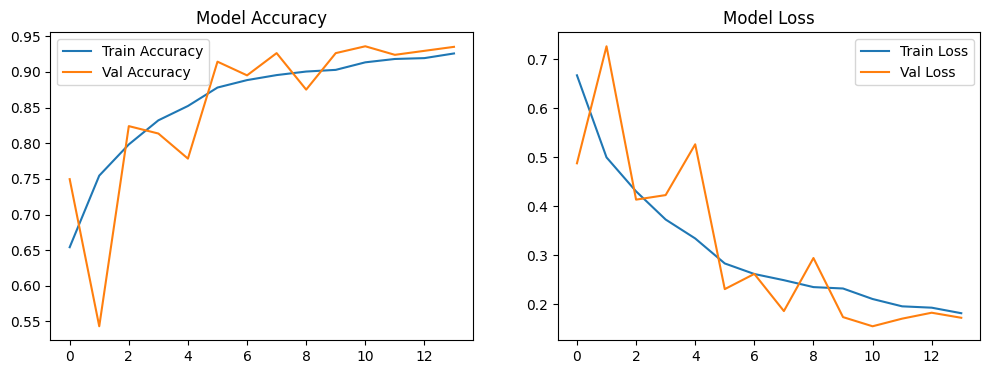

In [23]:
# Sau khi training xong
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cat_dog.history['accuracy'], label='Train Accuracy')
plt.plot(cat_dog.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(cat_dog.history['loss'], label='Train Loss')
plt.plot(cat_dog.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [24]:
# Bảng so sánh Train vs Validation (dùng .history)
hist = cat_dog.history
train_acc = hist['accuracy']
val_acc   = hist['val_accuracy']
train_loss = hist['loss']
val_loss   = hist['val_loss']

final_epoch = len(train_acc) - 1
best_val_acc_epoch  = int(np.argmax(val_acc))
best_val_loss_epoch = int(np.argmin(val_loss))

compare_df = pd.DataFrame({
    'Type': ['Final', 'Best Val Acc', 'Best Val Loss'],
    'Epoch': [final_epoch, best_val_acc_epoch, best_val_loss_epoch],
    'Train Accuracy': [train_acc[final_epoch], train_acc[best_val_acc_epoch], train_acc[best_val_loss_epoch]],
    'Val Accuracy':   [val_acc[final_epoch],   val_acc[best_val_acc_epoch],   val_acc[best_val_loss_epoch]],
    'Train Loss':     [train_loss[final_epoch], train_loss[best_val_acc_epoch], train_loss[best_val_loss_epoch]],
    'Val Loss':       [val_loss[final_epoch],   val_loss[best_val_acc_epoch],   val_loss[best_val_loss_epoch]],
})
pd.set_option('display.float_format','{:.4f}'.format)
display(compare_df)

,Type,Epoch,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,Final,13,0.9259,0.9352,0.1813,0.1720
1,Best Val Acc,10,0.9135,0.9360,0.2104,0.1547
2,Best Val Loss,10,0.9135,0.9360,0.2104,0.1547


<Figure size 480x480 with 0 Axes>

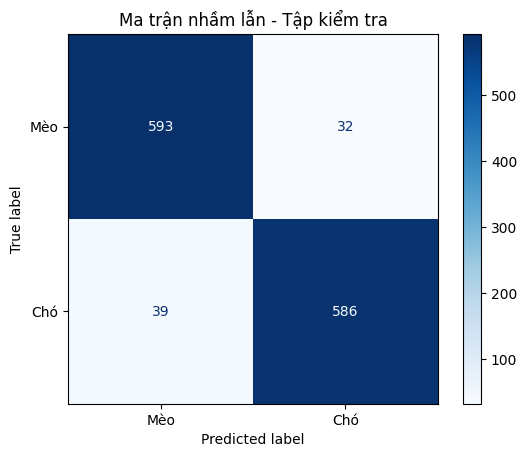


📊 Báo cáo phân loại (Tập kiểm tra):
              precision    recall  f1-score   support

         Mèo     0.9383    0.9488    0.9435       625
         Chó     0.9482    0.9376    0.9429       625

    accuracy                         0.9432      1250
   macro avg     0.9433    0.9432    0.9432      1250
weighted avg     0.9433    0.9432    0.9432      1250



In [25]:
# Dự đoán trên tập test
result = model.predict(test_gen, verbose=0)
y_pred = (result > 0.5).astype(int).ravel()
y_true = test_gen.labels

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Mèo', 'Chó'])

plt.figure(figsize=(4.8, 4.8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Ma trận nhầm lẫn - Tập kiểm tra')
plt.show()

print("\n📊 Báo cáo phân loại (Tập kiểm tra):")
print(classification_report(y_true, y_pred, target_names=['Mèo', 'Chó'], digits=4))

In [26]:
# ==================== ĐÁNH GIÁ MÔ HÌNH ====================

# Đánh giá trên tập train
loss_train, acc_train = model.evaluate(train_gen, batch_size=bat_size, verbose=0)
print(f"Độ chính xác (Accuracy) trên tập TRAIN: {acc_train*100:.2f}%")
print(f"Giá trị Loss trên tập TRAIN: {loss_train:.4f}")

# Đánh giá trên tập validation
loss_val, acc_val = model.evaluate(val_gen, batch_size=bat_size, verbose=0)
print(f"Độ chính xác (Accuracy) trên tập VALIDATION: {acc_val*100:.2f}%")
print(f"Giá trị Loss trên tập VALIDATION: {loss_val:.4f}")

# Đánh giá trên tập test
loss_test, acc_test = model.evaluate(test_gen, batch_size=bat_size, verbose=0)
print(f"Độ chính xác (Accuracy) trên tập TEST: {acc_test*100:.2f}%")
print(f"Giá trị Loss trên tập TEST: {loss_test:.4f}")


d:\DH_GTVT\NNLT_PY\.venvMiyae\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning:

Truncated File Read



Độ chính xác (Accuracy) trên tập TRAIN: 93.73%
Giá trị Loss trên tập TRAIN: 0.1577
Độ chính xác (Accuracy) trên tập VALIDATION: 93.60%
Giá trị Loss trên tập VALIDATION: 0.1547
Độ chính xác (Accuracy) trên tập TEST: 94.32%
Giá trị Loss trên tập TEST: 0.1388


# 6) Demo suy luận (Gradio multiple images)

In [ ]:
import gradio as gr
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
from pathlib import Path

BASE_DIR = Path(".")
MODEL_PATH = BASE_DIR / "model_cat_vs_dog_classification_final.h5"

model = load_model(str(MODEL_PATH))
IMG_SIZE = 128

def du_doan_nhieu_anh(files):
    ket_qua = []
    for f in files:

        img = Image.open(f).convert("RGB")
        img_resized = img.resize((IMG_SIZE, IMG_SIZE))
        arr = np.expand_dims(np.array(img_resized) / 255.0, axis=0)

        p = model.predict(arr)[0][0]

        if p > 0.5:
            label = "🐶 Chó"
            tin_cay = p * 100
        else:
            label = "🐱 Mèo"
            tin_cay = (1 - p) * 100

        ket_qua.append((img, f"{label} ({tin_cay:.2f}%)"))

    return ket_qua

demo = gr.Interface(
    fn=du_doan_nhieu_anh,
    inputs=gr.File(label="📸 Chọn một hoặc nhiều ảnh", file_count="multiple", type="filepath"),
    outputs=gr.Gallery(label="🔍 Kết quả dự đoán", show_label=True),
    title="🐾 Phân loại ảnh Chó và Mèo",
    description="Tải lên ảnh bất kỳ để mô hình dự đoán xem đó là 🐶 **Chó** hay 🐱 **Mèo** cùng với độ tin cậy (%)"
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "d:\DH_GTVT\NNLT_PY\.venvMiyae\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "d:\DH_GTVT\NNLT_PY\.venvMiyae\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "d:\DH_GTVT\NNLT_PY\.venvMiyae\lib\site-packages\fastapi\applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "d:\DH_GTVT\NNLT_PY\.venvMiyae\lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "d:\DH_GTVT\NNLT_PY\.venvMiyae\lib\site-packages\starlette\middleware\errors.py", line 186, in __call__
    raise exc
  File "d:\DH_GTVT\NNLT_PY\.venvMiyae\lib\site-packages\starlette\middleware\errors.py", line 164, in __call__
    await self.app(scope, receive, _s

1/1 [==============================] - 0s 20ms/step
